# Visualising outbreak curves - on different samples

## Reading and cleaning  the data

Import things

In [1]:
#%reset # ensures I am starting from scratch when appending dataframes

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pylab as plt
from os.path import isfile, join
from glob import glob

import seaborn as sns
sns.set(style="darkgrid")

In [2]:
#set file paths

path = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output/"
path_raw = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output/raw/"
path_raw_input = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\raw/"
path_output = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output\direct_output/larger_samples/"

Identify the input files and read them in

### Comparing different beta results 

Sets of simulation results can also be explored in the aggregate.

In [3]:
outputFiles = ["exportMe_1017_180_016_20p.txt", "exportMe_1017_180_016_50p.txt", "exportMe_1017_180_016_75p.txt", 
               "exportMe_1017_180_016_100p_v2.txt"] 

import re #enables multiple split criteria in one string

seed = '1017'
beta = '0.016'
run_length = 180 

#define the parameters to go into the function
for x in outputFiles :
    exportMe = pd.read_csv(path_output+x, sep='\t')
    exportMe['districtId'] = [int(str(x).split('_')[1]) for x in exportMe["myId"]] 
    exportMe['sample_size'] = (re.split('016_|.txt', x)[1]) 
    exportMe = exportMe.drop('Unnamed: 8', axis=1)
    exportMe.reset_index(drop=True)
    exportMe.to_csv(path_output+'to_append'+x)
    exportMe['seed'] = '1017'
    exportMe['beta'] = '0.016'
    exportMe['run_length']='variable'


In [4]:
#append all files with different seeds outputs together (run at the end when all are created)
exports = glob(path_output+'to_append*')

exports.sort()

ema_exports = pd.concat((pd.read_csv(export, sep='\t') for export in exports), ignore_index=False)

# export to csv
ema_exports.to_csv(path_output+'ema_appended_all_cols.csv', sep='\t')
ema_exports= pd.read_csv(path_output+'ema_appended_all_cols.csv', sep=',')

ema_exports['sample_size'].value_counts()

20p        10800
50p         6840
75p         4980
100p_v2     3960
Name: sample_size, dtype: int64

In [5]:
## create a scaled up variable of cases and deaths different for each sample size


ema_exports['scaled_sim_cases'] = np.where(
        ema_exports['sample_size'] == '20p', ema_exports['metric_new_cases_sympt']*5, 
    np.where(
        ema_exports['sample_size'] == '50p', ema_exports['metric_new_cases_sympt']*2,
    np.where(
        ema_exports['sample_size'] == '75p', ema_exports['metric_new_cases_sympt']*1.33,
        ema_exports['metric_new_cases_sympt']
            ))) # don't forget to add back a ')' for each new condition 


ema_exports['scaled_sim_deaths'] = np.where(
        ema_exports['sample_size'] == '20p', ema_exports['metric_new_deaths']*5, 
    np.where(
        ema_exports['sample_size'] == '50p', ema_exports['metric_new_deaths']*2,
    np.where(
        ema_exports['sample_size'] == '75p', ema_exports['metric_new_deaths']*1.33,
        ema_exports['metric_new_deaths']
            ))) # don't forget to add back a ')' for each new condition 


ema_exports['scaled_cum_deaths'] = np.where(
        ema_exports['sample_size'] == '20p', ema_exports['metric_died_count']*5, 
    np.where(
        ema_exports['sample_size'] == '50p', ema_exports['metric_died_count']*2,
    np.where(
        ema_exports['sample_size'] == '75p', ema_exports['metric_died_count']*1.33,
        ema_exports['metric_died_count']
            ))) # don't forget to add back a ')' for each new condition 

ema_exports.head()

# ##this also works but Kash said it was confusing, it is Stata way around of create then change. 
# ema_exports['scaled_sim_cases'] = np.where(
#     ema_exports['sample_size'] == '100p_v2', ema_exports['metric_new_cases_sympt'], np.where(
#     ema_exports['sample_size'] == '50p', ema_exports['metric_new_cases_sympt']*2, ema_exports['metric_new_cases_sympt']*5)) 

# https://stackoverflow.com/questions/21702342/creating-a-new-column-based-on-if-elif-else-condition 


,\t,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,districtId,sample_size,scaled_sim_cases,scaled_sim_deaths,scaled_cum_deaths
0,0\t0,0,d_38,0,0,0,0,0,0,38,100p_v2,0.0,0.0,0.0
1,1\t1,0,d_39,0,0,0,0,0,0,39,100p_v2,0.0,0.0,0.0
2,2\t2,0,d_47,0,0,0,0,0,0,47,100p_v2,0.0,0.0,0.0
3,3\t3,0,d_48,0,0,0,16,24,0,48,100p_v2,24.0,0.0,0.0
4,4\t4,0,d_45,0,0,0,0,0,0,45,100p_v2,0.0,0.0,0.0


In [6]:
# just checking the other conditions 
#ema_exports[ema_exports['sample_size'] == '20p']

In [8]:
# create a national level versions with just cases and deaths for each sample 
nat_level = ema_exports.groupby(['time', 'sample_size']).agg({'metric_new_cases_sympt':np.sum, 'scaled_sim_cases':np.sum, 'metric_died_count':np.sum, 'scaled_cum_deaths':np.sum})
nat_level['metric_died_count']=nat_level['metric_died_count'].astype(int)
nat_level.to_csv(path_output+'nat_level_samples.csv')
nat_level.head(10)


metric_new_cases_sympt  scaled_sim_cases  metric_died_count  \
time sample_size                                                                
0    100p_v2                          76              76.0                  0   
     20p                              15              75.0                  0   
     50p                               8              16.0                  0   
     75p                              70              93.1                  0   
1    100p_v2                           0               0.0                  0   
     20p                               0               0.0                  0   
     50p                               0               0.0                  0   
     75p                               0               0.0                  0   
2    100p_v2                           0               0.0                  0   
     20p                               0               0.0                  0   

                  scaled_cum_deaths  
time sample_size                     
0    100p_v2                    0.0  
     20p                        0.0  
     50p                        0.0  
     75p                        0.0  
1    100p_v2                    0.0  
     20p                        0.0  
     50p                        0.0  
     75p                        0.0  
2    100p_v2                    0.0  
     20p                        0.0

## Make national level graphs with multiple lines

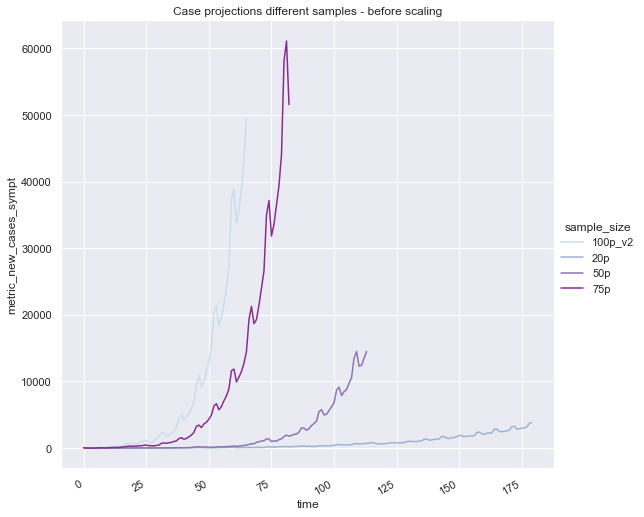

In [9]:
g = sns.relplot(x="time", y="metric_new_cases_sympt", kind="line", hue="sample_size", ci=None, data=nat_level, height = 8, palette = "BuPu").set(title="Case projections different samples - before scaling")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/national/sample_sizes/sim_cases_sample_runs.png')

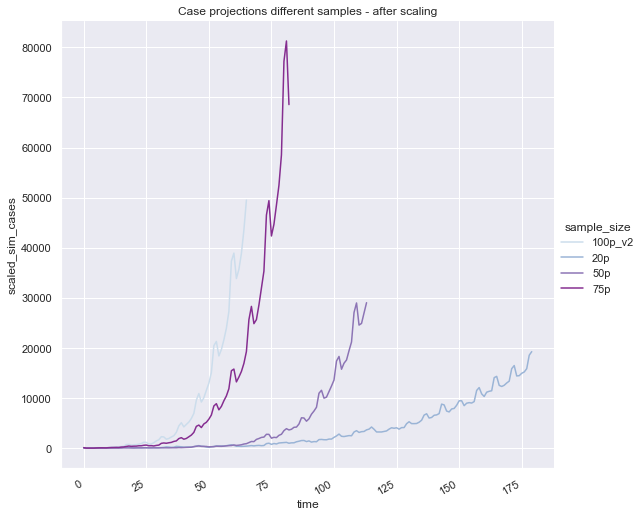

In [10]:
g = sns.relplot(x="time", y="scaled_sim_cases", kind="line", hue="sample_size", ci=None, data=nat_level, height=8, palette = "BuPu").set(title="Case projections different samples - after scaling")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/national/sample_sizes/sim_cases_scaled_sample_runs.png')

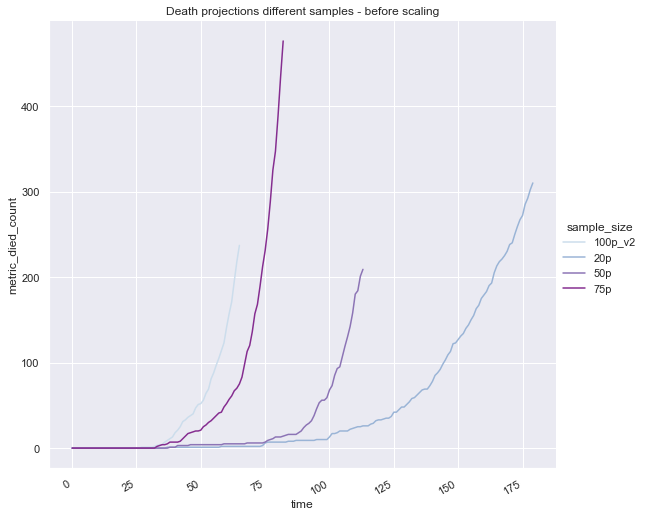

In [11]:
g = sns.relplot(x="time", y="metric_died_count", kind="line", hue="sample_size", ci=None, height=8, data=nat_level, palette = "BuPu").set(title="Death projections different samples - before scaling")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/national/sample_sizes/sim_deaths_sample_runs.png')

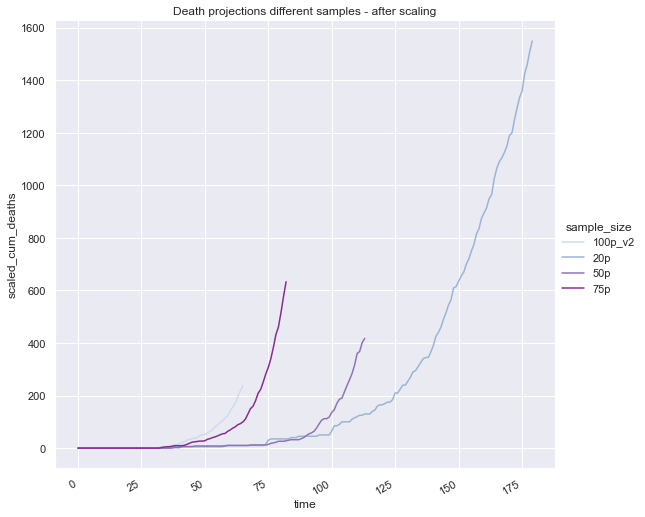

In [12]:
g = sns.relplot(x="time", y="scaled_cum_deaths", kind="line", hue="sample_size", ci=None, height=8, data=nat_level, palette = "BuPu").set(title="Death projections different samples - after scaling")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/national/sample_sizes/sim_deaths_scaled_10betaruns.png')

### Process first case files 

In [13]:
# keeping only where the number of either symptomatic or asymptomatic is >0
cases = ema_exports[(ema_exports.metric_new_cases_sympt > 0) | (ema_exports.metric_new_cases_asympt > 0)]
cases = cases.drop('\t', axis=1)
cases.head()


,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,districtId,sample_size,scaled_sim_cases,scaled_sim_deaths,scaled_cum_deaths
3,0,d_48,0,0,0,16,24,0,48,100p_v2,24.0,0.0,0.0
8,0,d_2,0,0,0,25,15,0,2,100p_v2,15.0,0.0,0.0
10,0,d_1,0,0,0,19,21,0,1,100p_v2,21.0,0.0,0.0
31,0,d_18,0,0,0,24,16,0,18,100p_v2,16.0,0.0,0.0
250,4,d_1,0,0,0,0,1,0,1,100p_v2,1.0,0.0,0.0


In [14]:
# keep the min time value by district equivalent to first case by district 
first_cases = cases.groupby(['sample_size','districtId']).agg({'time': 'min'})
first_cases.sort_values(by="time")

# sophie adding want to rename 'time' to denote the day of simulation
first_cases.rename(columns={'time':'simDay_firstcase'}, inplace=True)

#add variables to denote seed of the run, beta value & no. days
files= [first_cases]
for x in files: 
   # x ['beta'] = beta
    x ['run_length']= run_length
    x.reset_index(level=['districtId', 'sample_size'], inplace=True)

# #create a dataframe of this that I can aggregate afterwards
first_cases.to_csv(path_output+'first_cases_dif_samples.csv')



In [15]:
# read in the first districts cases data (what she called 'gold standard data')
gold_filename = (path+"../preprocessed/line_list/true.txt")
g_data = pd.read_csv(gold_filename, sep='\t')
g_data["trueDay"] = [int(x) for x in g_data['day']] ## this has just made another variable for the true day which is int format 
g_data.head()

,day,districtId,district_name_shpfile,cases_by_district_per_day,tot_cases_by_district,trueDay
0,1,1,Bulawayo,1,1044,1
1,5,18,Goromonzi,1,35,5
2,35,26,Chegutu,3,104,35
3,40,21,Murehwa,1,26,40
4,57,17,Chikomba,1,17,57


In [16]:
# m:1 merge on this data (in true/gold data, we have all 60 districts uniquely)
# note the gold data will get replicated across all 10 seeds if works correctly
# join the simulated and gold standard data based on the district ID
ema_plus_gold = pd.merge (first_cases, g_data, on = 'districtId', how='outer', validate='many_to_one')
ema_plus_gold.head(20)

# for the true first days for which there are multiple districts, I need to separate them out. e.g. day 1: Harare=1.1 + Buluwayo=1.2

ema_plus_gold['trueDay_sep']= ema_plus_gold['day'].astype(str) + '.'+ ema_plus_gold['districtId'].astype(str)
ema_plus_gold['trueDay_sep']= ema_plus_gold['trueDay_sep'].astype(float)
# for i in ema_plus_gold.day:
#     if i.find([''])

ema_plus_gold= ema_plus_gold[['districtId', 'district_name_shpfile',  'trueDay_sep','trueDay','simDay_firstcase', 'sample_size', 'run_length' ]]  #'trueDay_sep',
ema_plus_gold.to_csv(path_output+'ema_plus_gold.csv')
ema_plus_gold.head()

,districtId,district_name_shpfile,trueDay_sep,trueDay,simDay_firstcase,sample_size,run_length
0,1,Bulawayo,1.1,1,0,100p_v2,180
1,1,Bulawayo,1.1,1,0,20p,180
2,1,Bulawayo,1.1,1,0,50p,180
3,1,Bulawayo,1.1,1,0,75p,180
4,2,Harare,1.2,1,0,100p_v2,180


## Box plotting the district level comparisons 

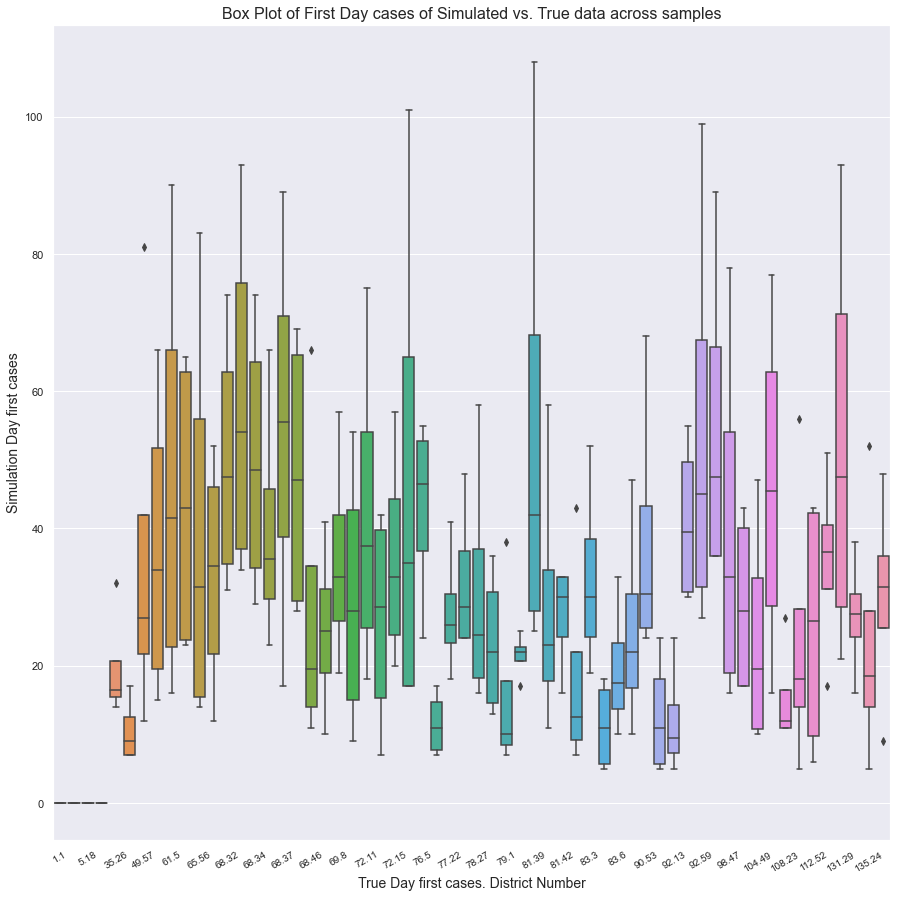

In [17]:
fig, ax = plt.subplots (figsize = (15, 15))
ax = sns.boxplot(
                x='trueDay_sep', 
                y='simDay_firstcase',
                data=ema_plus_gold)
ax.axes.set_title("Box Plot of First Day cases of Simulated vs. True data across samples", fontsize=16)
ax.set_xlabel("True Day first cases. District Number", fontsize=14)
ax.set_ylabel("Simulation Day first cases", fontsize=14)


# make sure x axis labels are visible
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, size = 10)
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
        
from matplotlib.ticker import FormatStrFormatter
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
#put on same scale
# ax.set(xlim=(0, 179), ylim=(0, 179)) # in true day the max first day is 136, in sim the max first day is 179
# xl, yl = [0,179], [0,179]
# sns.lineplot(xl, yl, linestyle='--', color='red')

# Be sure to only pick integer tick locations.
# import matplotlib.ticker as ticker

# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.savefig(path+'plots/district/box_plots/sample_sizes/first_cases_dist_diff_samples_incl_asympt.png')
# Nice example code here https://stackabuse.com/seaborn-box-plot-tutorial-and-examples/